#DATA PREPROCESSING (5)





# Imports and device setup




In [ ]:
# Import necessary libraries
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import zipfile
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from torch.utils.data import random_split, DataLoader

import torch
import torchvision
from PIL import Image
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Check PyTorch and torchvision versions
print("Torch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)

# Set device to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Torch version: 2.5.1+cu121
Torchvision version: 0.20.1+cu121
Device: cpu


In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')


# UNZIPPING THE DATASETS
with zipfile.ZipFile('/content/drive/MyDrive/finetuning/images_training_rev1.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/image_train')

# Path to the main zip file
zip_file_path = '/content/drive/MyDrive/finetuning/images_test_rev1.zip'
output_dir = '/content/image_test'

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Function to recursively unzip files
def unzip_all(zip_path, extract_to):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
        for root, _, files in os.walk(extract_to):
            for file in files:
                if file.endswith('.zip'):
                    nested_zip_path = os.path.join(root, file)
                    nested_output_dir = os.path.join(root, file.replace('.zip', ''))
                    os.makedirs(nested_output_dir, exist_ok=True)
                    unzip_all(nested_zip_path, nested_output_dir)  # Recursively unzip nested zip files
                    os.remove(nested_zip_path)  # Optionally remove nested zip file after extraction

# Unzip the main file and handle nested zips
unzip_all(zip_file_path, output_dir)


Mounted at /content/drive


In [ ]:
# LOADING IMAGE PATH IMAGES AND LABELS
image_dir = '/content/image_train/images_training_rev1'  # Path to training images
labels_path = '/content/training_solutions_rev1.csv'  # Path to labels CSV

# Load labels
labels_df = pd.read_csv(labels_path)
print("Labels loaded:", labels_df.shape)

Labels loaded: (61578, 38)


In [ ]:
df_train, df_test = train_test_split(labels_path[:30000], test_size=.2)
# df_train.shape, df_test.shape
import numpy as np

# Convert the list to a NumPy array
arr = np.array(df_train,df_test)

# Now you can use the `.shape` attribute
print(arr.shape)


NameError: name 'train_test_split' is not defined

2)DATA PREPROCESS; CUSTOM DATASET

In [ ]:
from skimage.transform import resize
from tqdm import tqdm # progress which the model
import matplotlib.pyplot as plt
%matplotlib inline


ORIG_SHAPE = (424,424)
CROP_SIZE = (256,256)
IMG_SHAPE = (64,64)

def get_image(path, x1,y1, shape, crop_size):
    x = plt.imread(path)
    x = x[x1:x1+crop_size[0], y1:y1+crop_size[1]]
    x = resize(x, shape)
    x = x/255.
    return x

def get_all_images(dataframe, shape=IMG_SHAPE, crop_size=CROP_SIZE):
    x1 = (ORIG_SHAPE[0]-CROP_SIZE[0])//2
    y1 = (ORIG_SHAPE[1]-CROP_SIZE[1])//2

    sel = dataframe.values
    ids = sel[:,0].astype(int).astype(str)
    y_batch = sel[:,1:]
    x_batch = []
    for i in tqdm(ids):
        x = get_image('/kaggle/working/images_training_rev1/'+i+'.jpg', x1,y1, shape=shape, crop_size=crop_size)
        x_batch.append(x)
    x_batch = np.array(x_batch)
    return x_batch, y_batch

X_train, y_train = get_all_images(df_train)
X_test, y_test = get_all_images(df_test)

NameError: name 'df_train' is not defined

In [ ]:
# DATA AUGUMENTATIONA AND NORMALIZATION FOR TRAINING
transform = transforms.Compose([
    transforms.Resize((100, 100)),    # Resize to 100x100 if needed
    transforms.ToTensor(),            # Convert to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize
])

#CUSTOM DTASET CLASS(GALAXY DATASET)
class GalaxyDataset(torch.utils.data.Dataset):
    def __init__(self, image_dir, labels_df, transform=None):
        self.image_dir = image_dir
        self.labels_df = labels_df
        self.transform = transform

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        # Assuming the image filename is in the first column
        img_filename = str(self.labels_df.iloc[idx, 0]) + '.jpg'  # Add .jpg extension if needed
        img_name = os.path.join(self.image_dir, img_filename)  # Adjust if there's a different file extension

        try:
            image = Image.open(img_name).convert('RGB')
        except FileNotFoundError:
            print(f"Image file not found: {img_name}")
            raise

        label = torch.tensor(self.labels_df.iloc[idx, 1:].values, dtype=torch.float32)  # labels as tensor
        if self.transform:
            image = self.transform(image)

        return image, label



3)SPLITTING:TRAINING, VALIDATION, TESTING

In [ ]:
# Create dataset and SPLIT TO TRAIN AND VALIDATION SETS AND TEST DATA SETS
from torch.utils.data import random_split, DataLoader

# Define the dataset
dataset = GalaxyDataset(image_dir, labels_df, transform=transform)

batch_size = 37  # or any other number you'd like to use for the batch size


# Define sizes for train, validation, and test sets
train_size = int(0.7 * len(dataset))  # 70% for training
valid_size = int(0.15 * len(dataset)) # 15% for validation
test_size = len(dataset) - train_size - valid_size  # Remaining 15% for testing

# Split the dataset
train_dataset, valid_dataset, test_dataset = random_split(dataset, [train_size, valid_size, test_size])

# Create data loaders for each split
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
validloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

testloader = DataLoader(test_dataset, batch_size=37, shuffle=False, num_workers=2)


Train batch shape: torch.Size([37, 3, 100, 100])
Train labels batch shape: torch.Size([37, 37])
Validation batch shape: torch.Size([37, 3, 100, 100])
Validation labels batch shape: torch.Size([37, 37])
Test batch shape: torch.Size([37, 3, 100, 100])
Test labels batch shape: torch.Size([37, 37])


In [ ]:
# Check the shape of a batch from the train loader
dataiter = iter(trainloader)
images, labels = next(dataiter)  # Use next(dataiter) instead of dataiter.next()
print("Train batch shape:", images.shape)
print("Train labels batch shape:", labels.shape)

# Check the shape of a batch from the validation loader
dataiter_valid = iter(validloader)
images_valid, labels_valid = next(dataiter_valid)
print("Validation batch shape:", images_valid.shape)
print("Validation labels batch shape:", labels_valid.shape)

# Check the shape of a batch from the test loader
dataiter_test = iter(testloader)
images_test, labels_test = next(dataiter_test)
print("Test batch shape:", images_test.shape)
print("Test labels batch shape:", labels_test.shape)

4.UTILITY FUNCTION

5)EXAMPLES



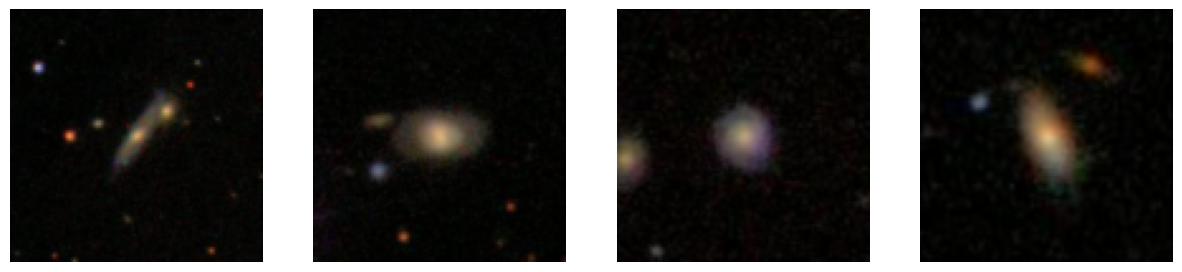

In [ ]:
# Example of loading and visualizing a batch OF IMAGES
fig, ax = plt.subplots(1, 4, figsize=(15, 5))
for i in range(4):
    ax[i].imshow(images[i].permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5)  # Unnormalize for visualization
    ax[i].axis('off')
plt.show()

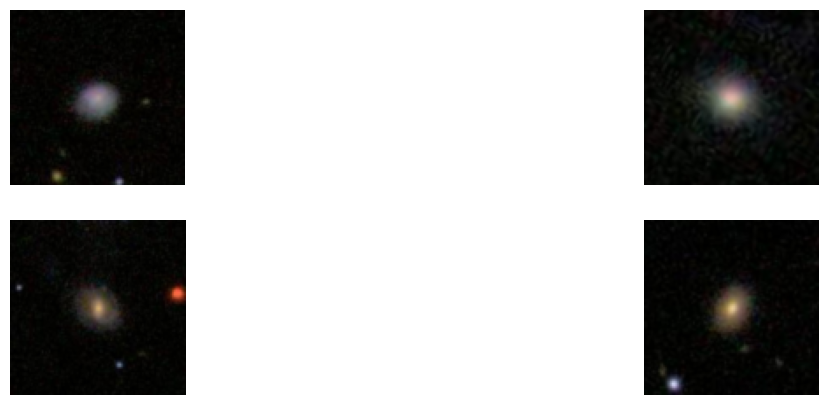

Images shape is: torch.Size([3, 100, 100])
Features length is: torch.Size([37])


In [ ]:
# Plot example function for PyTorch dataset
def plot_example(dataset, rows=2, cols=2):
    # Create a DataLoader to load one batch from the dataset
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=rows * cols, shuffle=True)
    # Get one batch
    images, labels = next(iter(dataloader))

    # Plot images
    fig, axes = plt.subplots(rows, cols, figsize=(15, 5))
    for i in range(rows):
        for j in range(cols):
            index = cols * i + j
            axes[i, j].imshow(images[index].permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5)  # Unnormalize for visualization
            axes[i, j].grid(False)
            axes[i, j].axis('off')

    plt.show()
    return images[0].shape, labels[0].shape

# Call the function and print shapes
image_shape, features_num = plot_example(train_dataset)
print("Images shape is: {}".format(image_shape))
print("Features length is: {}".format(features_num))


# 2.RESNET MODEL

In [ ]:
from transformers import AutoModelForImageClassification, AutoFeatureExtractor
from datasets import load_dataset
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm

In [ ]:


# Define the model checkpoint
model_checkpoint = "microsoft/resnet-50"

# Define label mappings for Galaxy Zoo (assume binary labels for simplicity; adapt as needed)
id2label = {i: f"Class {i}" for i in range(37)}
label2id = {f"Class {i}": i for i in range(37)}

# Load the pre-trained ResNet-50 model for image classification
model = AutoModelForImageClassification.from_pretrained(
    model_checkpoint,
    num_labels=37,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
)

# Load the feature extractor for ResNet-50
feature_extractor = AutoFeatureExtractor.from_pretrained(model_checkpoint)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/69.6k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

Some weights of ResNetForImageClassification were not initialized from the model checkpoint at microsoft/resnet-50 and are newly initialized because the shapes did not match:
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([37]) in the model instantiated
- classifier.1.weight: found shape torch.Size([1000, 2048]) in the checkpoint and torch.Size([37, 2048]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


preprocessor_config.json:   0%|          | 0.00/266 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/convnext/feature_extraction_convnext.py:28: FutureWarning: The class ConvNextFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ConvNextImageProcessor instead.
  warnings.warn(


In [ ]:
# Define RMSE function
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Prediction function with loss calculation
def predict(net, loader, record_y=False):
    y_pred_list = []
    net.eval()  # Set network to evaluation mode
    total_loss = 0.0
    total_sample = 0
    with torch.no_grad():
        for i, data in enumerate(loader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)

            current_sample = len(labels)
            total_sample += current_sample
            total_loss += loss.item() * current_sample

            if record_y:
                y_pred_list.append(outputs.cpu().numpy())

    avg_loss = total_loss / total_sample
    print(f"Average loss: {avg_loss}")

    if record_y:
        y_pred = np.concatenate(y_pred_list)
        return y_pred
    else:
        return avg_loss

In [ ]:
from transformers import AutoModelForImageClassification, AutoFeatureExtractor
from datasets import load_dataset
import evaluate  # Import the evaluate library
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm

#import accuracy evaluation metric
accuracy = evaluate.load("accuracy")

In [ ]:
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=1)

    return {"accuracy": accuracy.compute(predictions=predictions, references=labels)}

In [ ]:
# Inspect the classifier
print(model.classifier)  # Print to see its structure

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=2048, out_features=37, bias=True)
)


In [ ]:
# Get the last layer from the classifier
last_layer = model.classifier[-1]  # Assuming the last layer is a Linear layer

# Get the number of input features for the final layer
num_ftrs = last_layer.in_features  # Access in_features from the last layer

# Adjust the final layer for 37 classes
model.classifier[-1] = nn.Linear(num_ftrs, 37)  # Adjust for 37 classes

# Define the LORA adaptation layer
class LORALayer(nn.Module):
    def __init__(self, adapted_layer, rank=16):
        super(LORALayer, self).__init__()
        self.adapted_layer = adapted_layer
        self.rank = rank  # Set the rank for LoRA
        # Initialize low-rank matrices A and B
        self.A = nn.Parameter(torch.randn(adapted_layer.weight.size(1), rank) * 0.01)  # Initialize with small values
        self.B = nn.Parameter(torch.randn(rank, adapted_layer.weight.size(0)) * 0.01)  # Initialize with small values

    def forward(self, x):
        # Calculate the low-rank adaptation
        low_rank_matrix = self.A @ self.B
        adapted_weight = self.adapted_layer.weight + low_rank_matrix.t()  # Ensure correct shape
        return nn.functional.linear(x, adapted_weight, self.adapted_layer.bias)

# Apply LORA to the last layer of the model
model.classifier[-1] = LORALayer(last_layer)  # Replace last layer with LORA layer

# Optionally, move the model to the appropriate device (CPU/GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ResNetForImageClassification(
  (resnet): ResNetModel(
    (embedder): ResNetEmbeddings(
      (embedder): ResNetConvLayer(
        (convolution): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (normalization): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): ReLU()
      )
      (pooler): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (encoder): ResNetEncoder(
      (stages): ModuleList(
        (0): ResNetStage(
          (layers): Sequential(
            (0): ResNetBottleNeckLayer(
              (shortcut): ResNetShortCut(
                (convolution): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (normalization): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              )
              (layer): Sequential(
                (0): ResNetConvLayer(
                  (convolution): Conv2d(64

In [ ]:
from torch.optim import lr_scheduler
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)  # Move the model to the GPU if available
images = images.to(device)  # Move the input data to the same device as the model


import torch.nn as nn

# Choose an appropriate loss function based on your task
criterion = nn.CrossEntropyLoss()  # Example for classification



start_time = time.time()
outputs = model(images)
# print(f"Model inference time: {time.time() - start_time} seconds")


# start_time = time.time()
loss = criterion(outputs.logits.to(device), labels.to(device))
print(f"Loss calculation time: {time.time() - start_time} seconds")


num_epochs = 20




# Track losses and accuracies
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Implement a learning rate scheduler
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

best_val_accuracy = 0.0
best_model_wts = model.state_dict()

# Training Loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        # Get model outputs and extract logits
        outputs = model(images)

        # Extract logits
        if hasattr(outputs, 'logits'):
            logits = outputs.logits  # Extract the logits from the output
        else:
            raise ValueError("The model output does not have 'logits'. Check your model and output format.")

        loss = criterion(logits, labels)  # Use logits for loss calculation
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(logits.data, 1)  # Use logits for predictions

        # Ensure labels are 1D
        labels = torch.argmax(labels, dim=1) if labels.ndim > 1 else labels  # Convert if one-hot encoded

        # Ensure predicted and labels have the same size
        min_size = min(predicted.size(0), labels.size(0))
        correct += (predicted[:min_size] == labels[:min_size]).sum().item()
        total += min_size

    scheduler.step()  # Adjust the learning rate based on the scheduler
    train_accuracy = 100 * correct / total
    train_losses.append(running_loss / len(trainloader))
    train_accuracies.append(train_accuracy)

    # Validation phase
    model.eval()
    val_running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in validloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs.logits, labels)
            val_running_loss += loss.item()
            _, predicted = torch.max(outputs.logits, 1)

            # Ensure labels are 1D
            labels = torch.argmax(labels, dim=1) if labels.ndim > 1 else labels  # Convert if one-hot encoded

            # Ensure predicted and labels have the same size
            min_size = min(predicted.size(0), labels.size(0))
            correct += (predicted[:min_size] == labels[:min_size]).sum().item()
            total += min_size

    val_accuracy = 100 * correct / total
    val_losses.append(val_running_loss / len(validloader))
    val_accuracies.append(val_accuracy)

    # Save the model if validation accuracy improves
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_model_wts = model.state_dict()

    print(f'Epoch {epoch+1}, Train Loss: {running_loss / len(trainloader)}, Train Accuracy: {train_accuracy}%, Val Loss: {val_running_loss / len(validloader)}, Val Accuracy: {val_accuracy}%')


Loss calculation time: 2.4907867908477783 seconds
Epoch 1, Train Loss: 14.007143334424782, Train Accuracy: 66.7874059626637%, Val Loss: 13.86176473931615, Val Accuracy: 71.19287962661457%
Epoch 2, Train Loss: 13.728550261238595, Train Accuracy: 72.25782483514442%, Val Loss: 13.858881701427292, Val Accuracy: 74.28633452729838%
Epoch 3, Train Loss: 13.646151690958291, Train Accuracy: 73.9412092504876%, Val Loss: 13.802362323286065, Val Accuracy: 72.77759687398242%
Epoch 4, Train Loss: 13.591957968944536, Train Accuracy: 74.59830964985605%, Val Loss: 13.8130119660772, Val Accuracy: 76.18582437859547%
Epoch 5, Train Loss: 13.539102841898337, Train Accuracy: 75.23915668245566%, Val Loss: 13.756503947767388, Val Accuracy: 75.97959405188321%
Epoch 6, Train Loss: 13.481131167755914, Train Accuracy: 75.69425095198291%, Val Loss: 13.72762179853447, Val Accuracy: 72.54965809182677%
Epoch 7, Train Loss: 13.419750267697363, Train Accuracy: 75.87303798644005%, Val Loss: 13.790344345521735, Val Accur

In [ ]:
# Load the best model weights
model.load_state_dict(best_model_wts)

# Save the best model to disk
torch.save(model.state_dict(), 'best_model.pth')

Test Accuracy: 78.37837837837837%


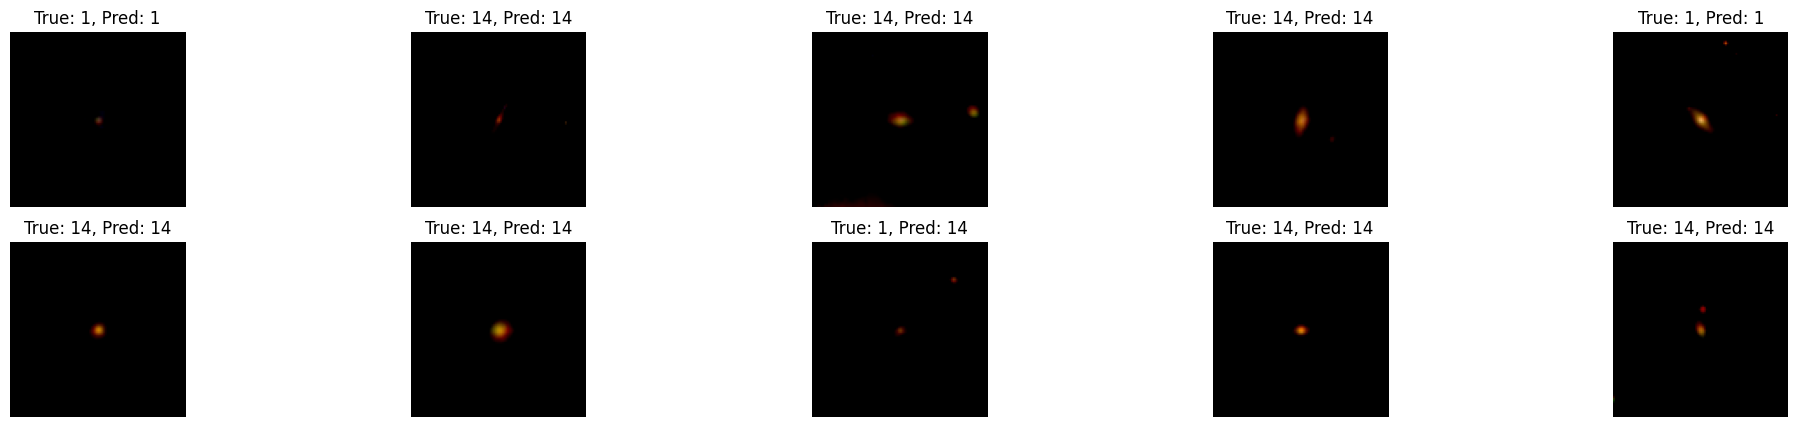

In [ ]:
import torch.nn.functional as F

# Test phase (after training is complete and best model is loaded)
model.eval()
correct = 0
total = 0
fig = plt.figure(figsize=(25, 5))  # Define figure size

# We will visualize the first 10 images of the test set
for i, (images, labels) in enumerate(testloader, start=1):
    if i > 10:  # Stop after visualizing 10 images
        break
    images, labels = images.to(device), labels.to(device)

    # Get the model outputs
    outputs = model(images)
    if hasattr(outputs, 'logits'):
        outputs = outputs.logits  # Extract logits if available

    # Convert one-hot encoded labels to class indices
    labels = torch.argmax(labels, dim=1)

    # Get predictions
    _, predicted = torch.max(outputs, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

    # Visualize the images and predictions
    ax = fig.add_subplot(2, 5, i)  # Plotting 10 images in 2 rows and 5 columns
    ax.imshow(images[0].cpu().numpy().transpose((1, 2, 0)))
    ax.set_title(f"True: {labels[0].item()}, Pred: {predicted[0].item()}")
    ax.axis('off')

test_accuracy = 100 * correct / total
print(f'Test Accuracy: {test_accuracy}%')
plt.show()


In [ ]:
from transformers import ResNetForImageClassification, Trainer, TrainingArguments
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader

# Define your dataset loading logic
def compute_metrics(pred):
    predictions, labels = pred
    rmse = np.sqrt(mean_squared_error(labels, predictions))
    return {"rmse": rmse}

# Fine-tuning setup
def fine_tune_model(train_dataset, val_dataset, model_name="microsoft/resnet-50"):
    model = ResNetForImageClassification.from_pretrained(model_name, num_labels=37)  # Update num_labels as needed
    training_args = TrainingArguments(
        output_dir="./results",
        evaluation_strategy="epoch",
        save_strategy="epoch",
        learning_rate=5e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=5,
        weight_decay=0.01,
        logging_dir="./logs",
        logging_steps=50,
        save_total_limit=2,
        load_best_model_at_end=True,
        metric_for_best_model="rmse",
        report_to="none",  # Disable W&B or similar tools
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics,
    )

    trainer.train()
    return trainer

In [ ]:
def predict_and_save(trainer, test_dataset, output_file="submission.csv"):
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
    predictions = []
    galaxy_ids = []

    for batch in test_loader:
        inputs = batch["pixel_values"]
        galaxy_ids.extend(batch["galaxy_id"])  # Assuming the dataset includes Galaxy IDs
        with torch.no_grad():
            outputs = trainer.model(inputs)
            preds = torch.softmax(outputs.logits, dim=-1).cpu().numpy()
            predictions.extend(preds)

    predictions = np.array(predictions)
    # Assuming you have the column names based on the submission format
    column_names = ["GalaxyID"] + [f"Class{i}" for i in range(1, predictions.shape[1] + 1)]
    submission_df = pd.DataFrame(predictions, columns=column_names[1:])
    submission_df.insert(0, "GalaxyID", galaxy_ids)
    submission_df.to_csv(output_file, index=False)
    print(f"Submission file saved as {output_file}")

In [ ]:
predict_and_save(trainer, test_dataset, output_file="fine_tuned_submission.csv")

NameError: name 'trainer' is not defined